# Step 1: Upload JSON files

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ceph_mds_cache_recovery_2025-04-18_135500-143000_UTC.json to ceph_mds_cache_recovery_2025-04-18_135500-143000_UTC.json
Saving ceph_num_objects_degraded_2025-04-18_135500-143000_UTC.json to ceph_num_objects_degraded_2025-04-18_135500-143000_UTC.json
Saving ceph_osd_flag_nobackfill_2025-04-18_135500-143000_UTC.json to ceph_osd_flag_nobackfill_2025-04-18_135500-143000_UTC.json
Saving ceph_osd_recovery_bytes_2025-04-18_135500-143000_UTC.json to ceph_osd_recovery_bytes_2025-04-18_135500-143000_UTC.json
Saving ceph_osd_recovery_ops_2025-04-18_135500-143000_UTC.json to ceph_osd_recovery_ops_2025-04-18_135500-143000_UTC.json
Saving ceph_pg_backfilling_2025-04-18_135500-143000_UTC.json to ceph_pg_backfilling_2025-04-18_135500-143000_UTC.json
Saving ceph_pg_degraded_2025-04-18_135500-143000_UTC.json to ceph_pg_degraded_2025-04-18_135500-143000_UTC.json
Saving ceph_pg_forced_recovery_2025-04-18_135500-143000_UTC.json to ceph_pg_forced_recovery_2025-04-18_135500-143000_UTC.json
Saving ceph_

# Step 2: Imports

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import re

# Step 3: Helper to extract metric from filename

In [ ]:
def extract_metric_name(filename):
    match = re.match(r'ceph_(.*?)_\d{4}-\d{2}-\d{2}_\d{6}-\d{6}_UTC', filename)
    return match.group(1) if match else None


# Step 4: Initialize final DataFrame

In [ ]:
df_final = pd.DataFrame()
metric_names = []

# Step 5: Process each file

In [ ]:
for filename in uploaded:
    metric = extract_metric_name(filename)
    if not metric:
        print(f"Could not extract metric from: {filename}. Skipping.")
        continue

    content = json.load(io.BytesIO(uploaded[filename]))
    try:
        values = content['data']['result'][0]['values']
    except (KeyError, IndexError):
        print(f"Skipping {filename}: no valid data found.")
        continue

    temp_df = pd.DataFrame(values, columns=['timestamp', metric])
    temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'], unit='s')
    temp_df[metric] = pd.to_numeric(temp_df[metric], errors='coerce')

    if df_final.empty:
        df_final = temp_df
    else:
        df_final = pd.merge(df_final, temp_df, on='timestamp', how='outer')

    metric_names.append(metric)

# Step 6: Final cleanup

In [ ]:
df_final = df_final.sort_values('timestamp').reset_index(drop=True)

# Step 7: Plot each metric over time

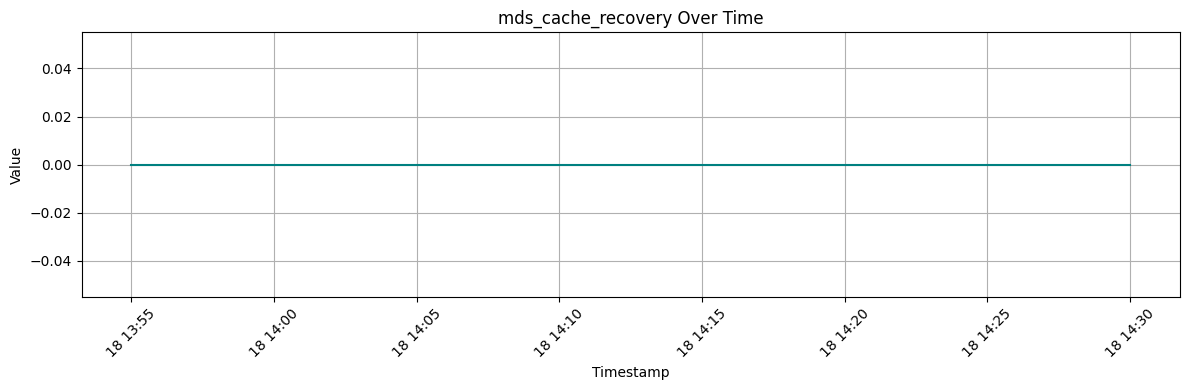

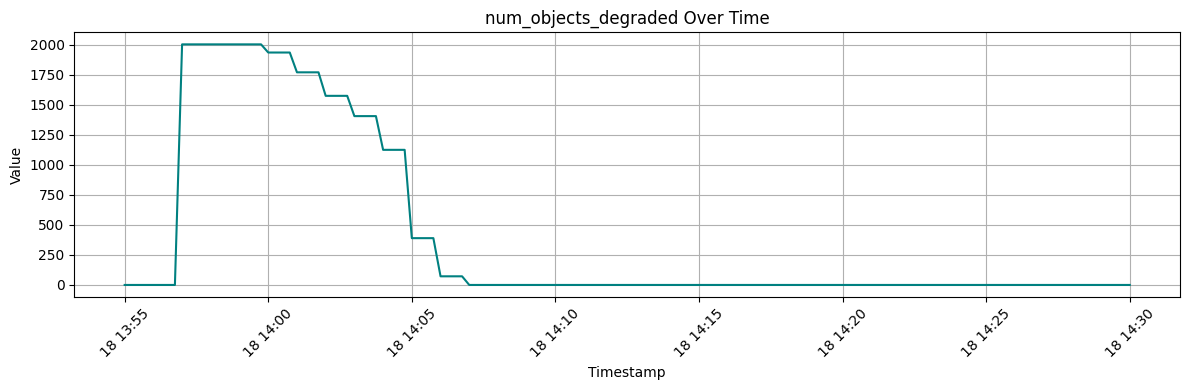

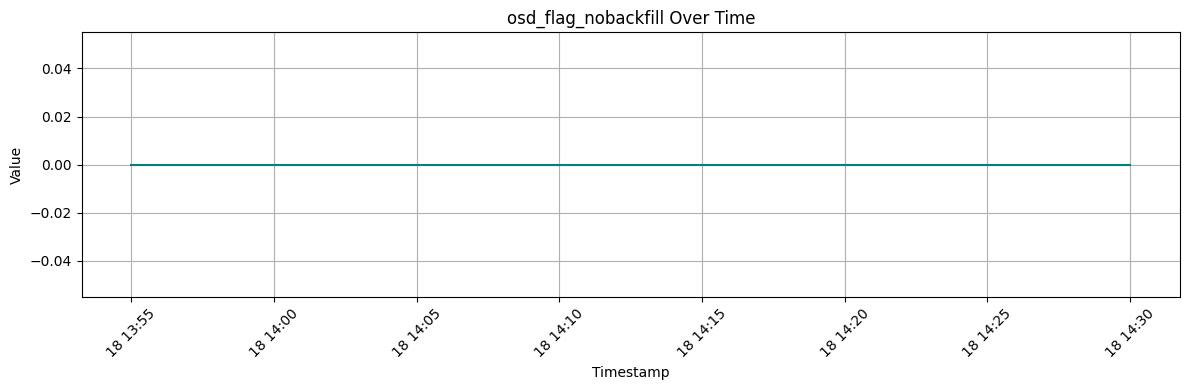

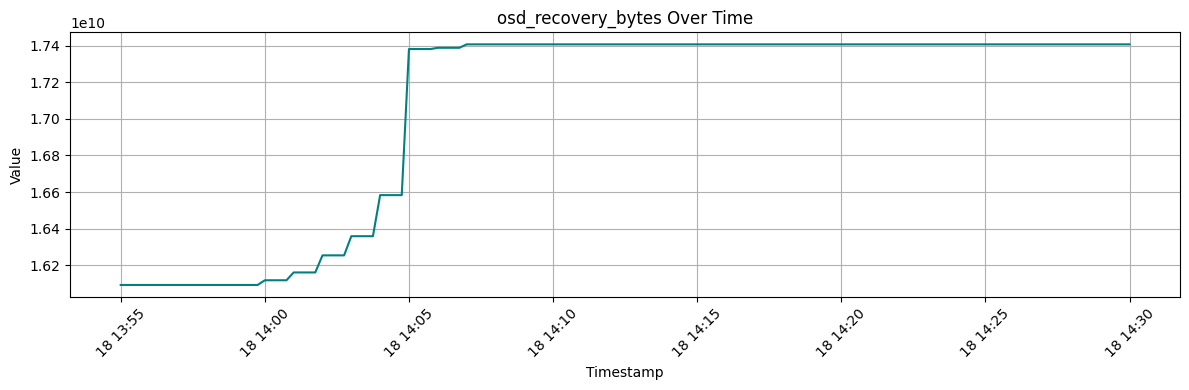

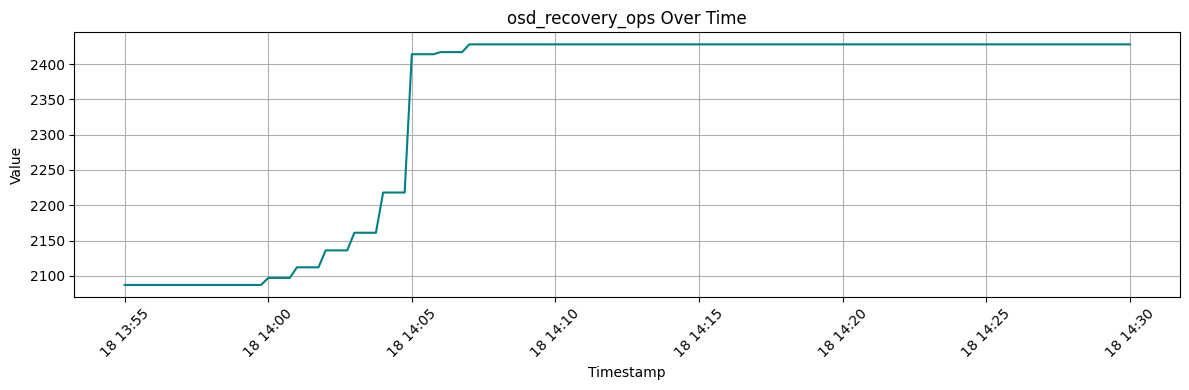

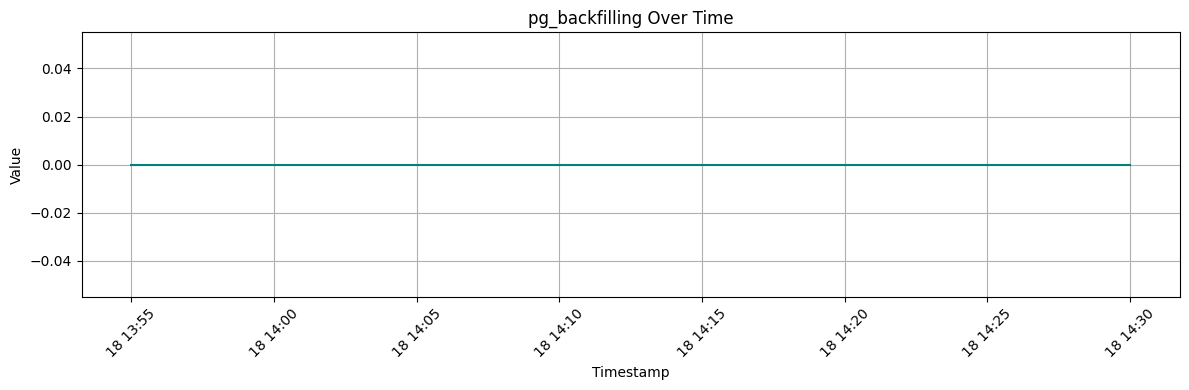

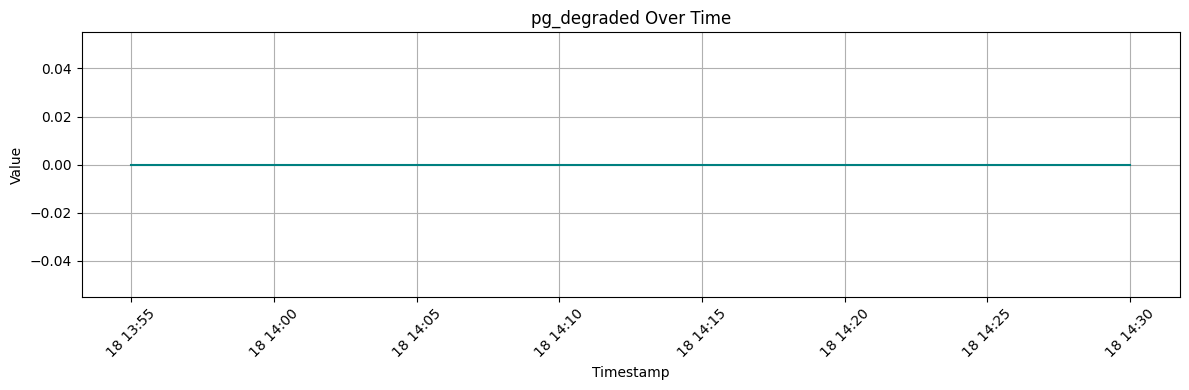

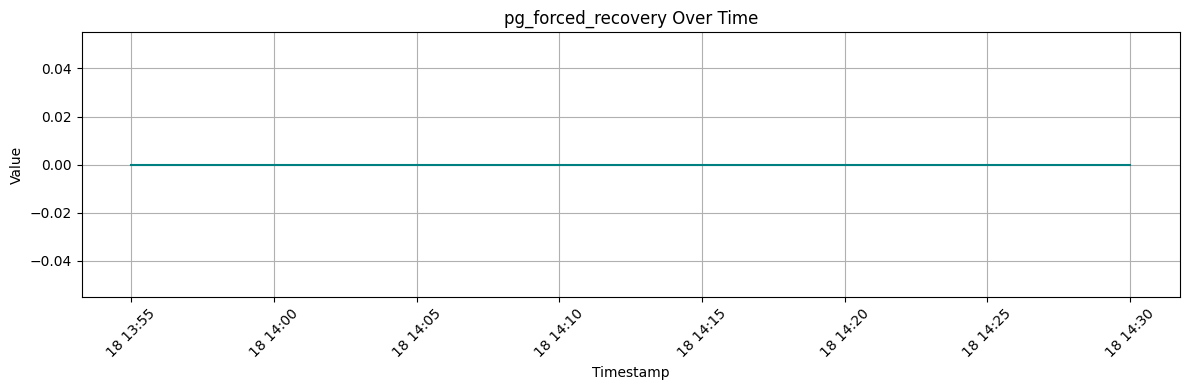

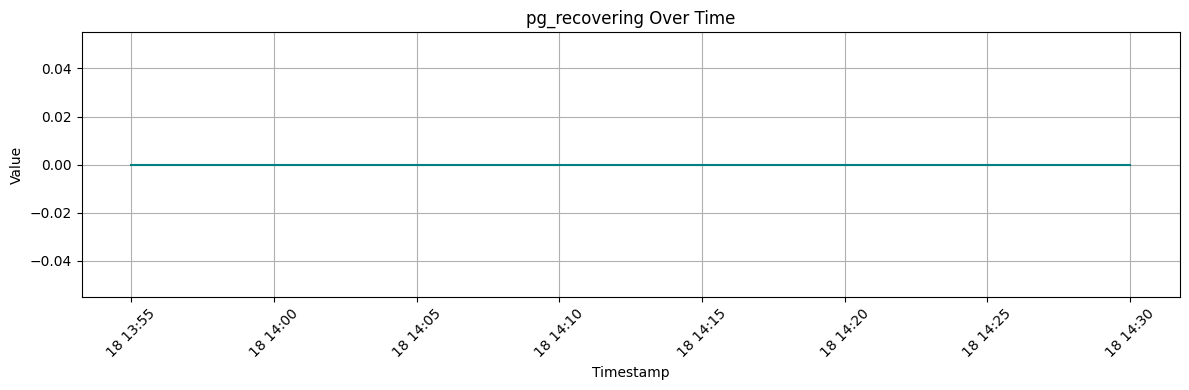

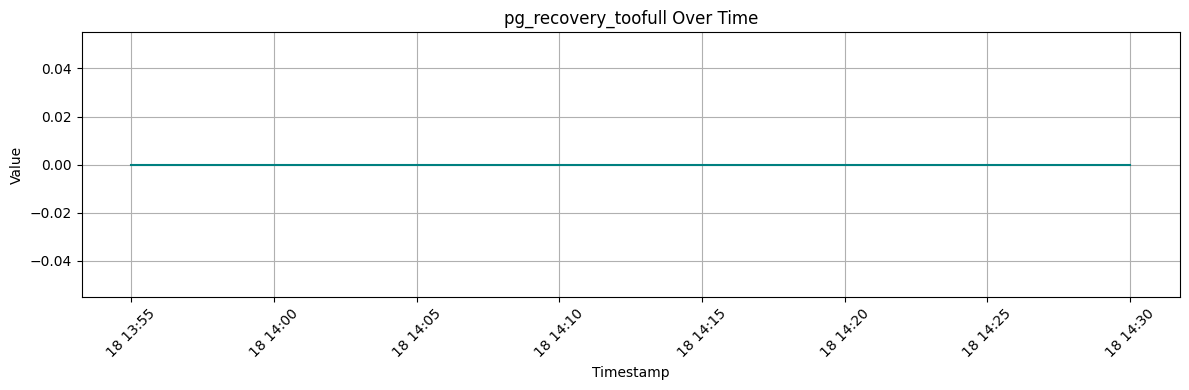

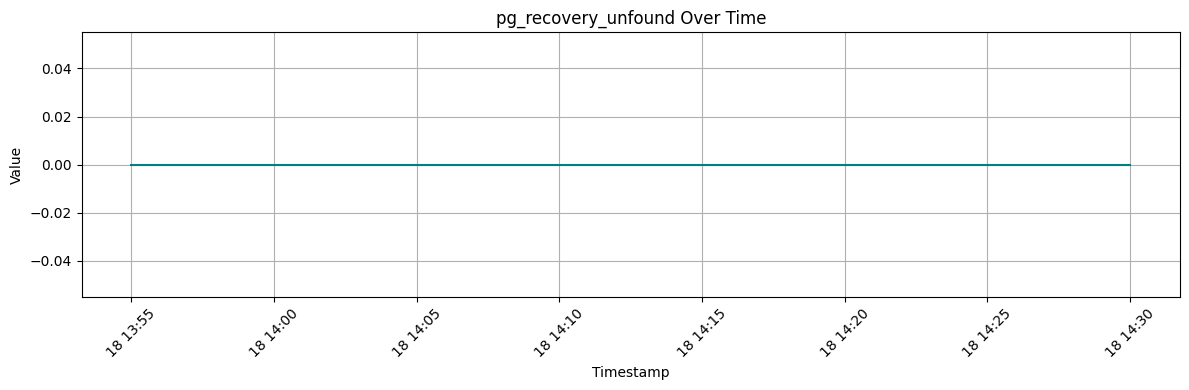

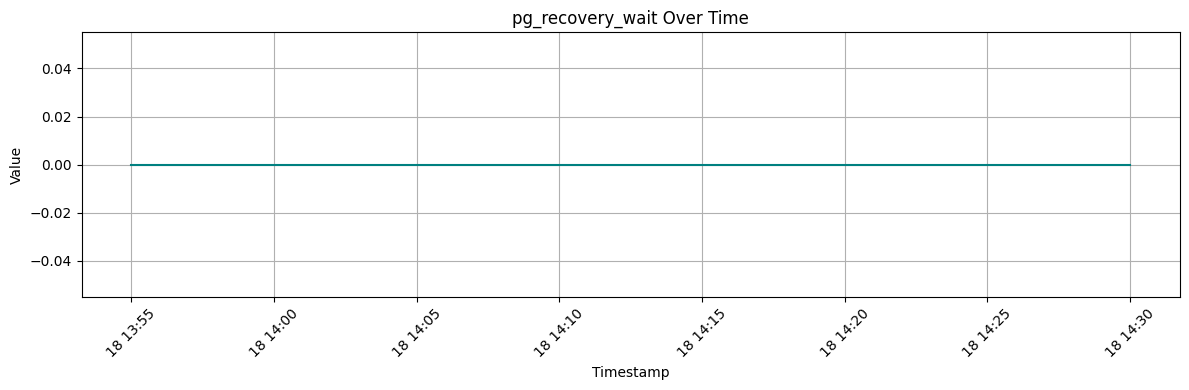

In [ ]:
for metric in metric_names:
    if metric in df_final.columns:
        plt.figure(figsize=(12, 4))
        plt.plot(df_final['timestamp'], df_final[metric], label=metric, color='teal')
        plt.title(f"{metric} Over Time")
        plt.xlabel("Timestamp")
        plt.ylabel("Value")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# Step 8: Correlation heatmap

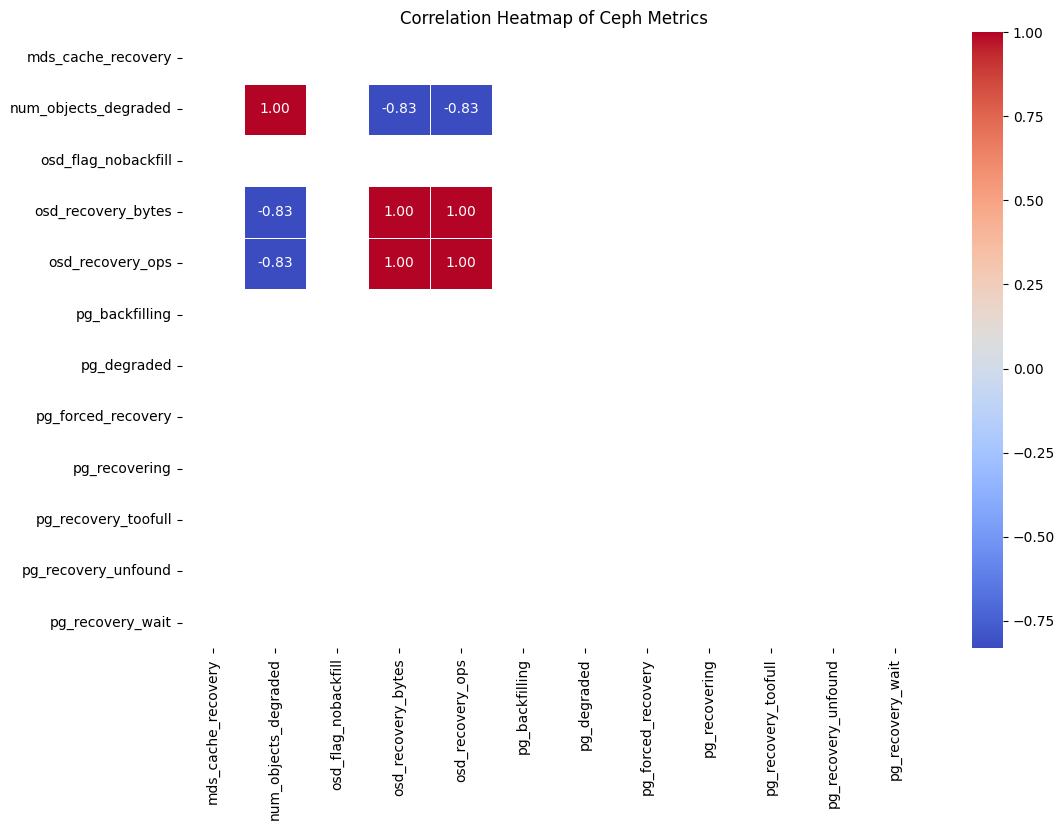

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_final[metric_names].corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Ceph Metrics")
plt.show()


## Conclusion Based on the above EDA


*   Out of all the 12 metrics only 3 metrics show variation over Time : _num_objects_degraded_, _osd_recovery_bytes_, _osd_recovery_ops_ according to the line graphs in **Step 7**.

*   Based on the Correlation Heatmap in **Step 8** we can say that there is no possible correlation between _num_objects_degraded_ and _osd_recovery_bytes_ or _osd_recovery_ops_. However _osd_recovery_bytes_ and _osd_recovery_ops_ are correlated.

*   So we can conclude that for time series analysis we must consider only _num_objects_degraded_, _osd_recovery_bytes_ and _osd_recovery_ops_ .



# Step 9: Focused heatmap for Selected Metrics

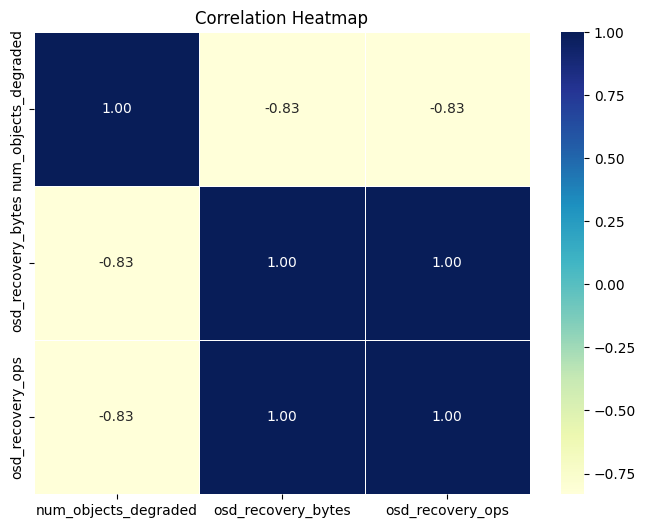

In [ ]:
selected_metrics = ['num_objects_degraded', 'osd_recovery_bytes', 'osd_recovery_ops']

# Make sure all selected metrics are in the dataframe
available_metrics = [metric for metric in selected_metrics if metric in df_final.columns]

# Generate correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_final[available_metrics].corr(), annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Step 10: Time Series Visualization of Selected Metrics

<ipython-input-11-527ff607ee0a>:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_ts = df_ts.resample('5S').mean()


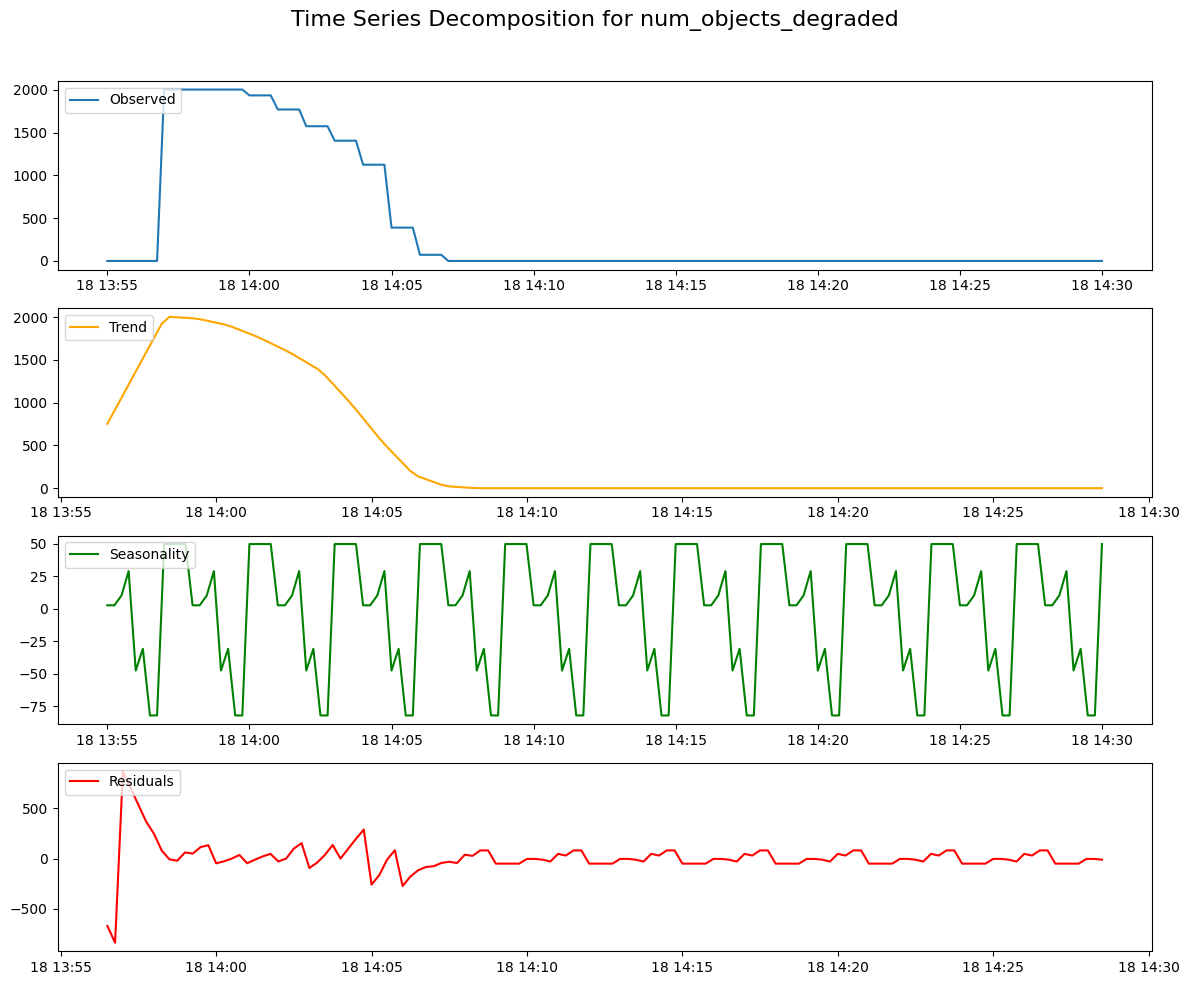

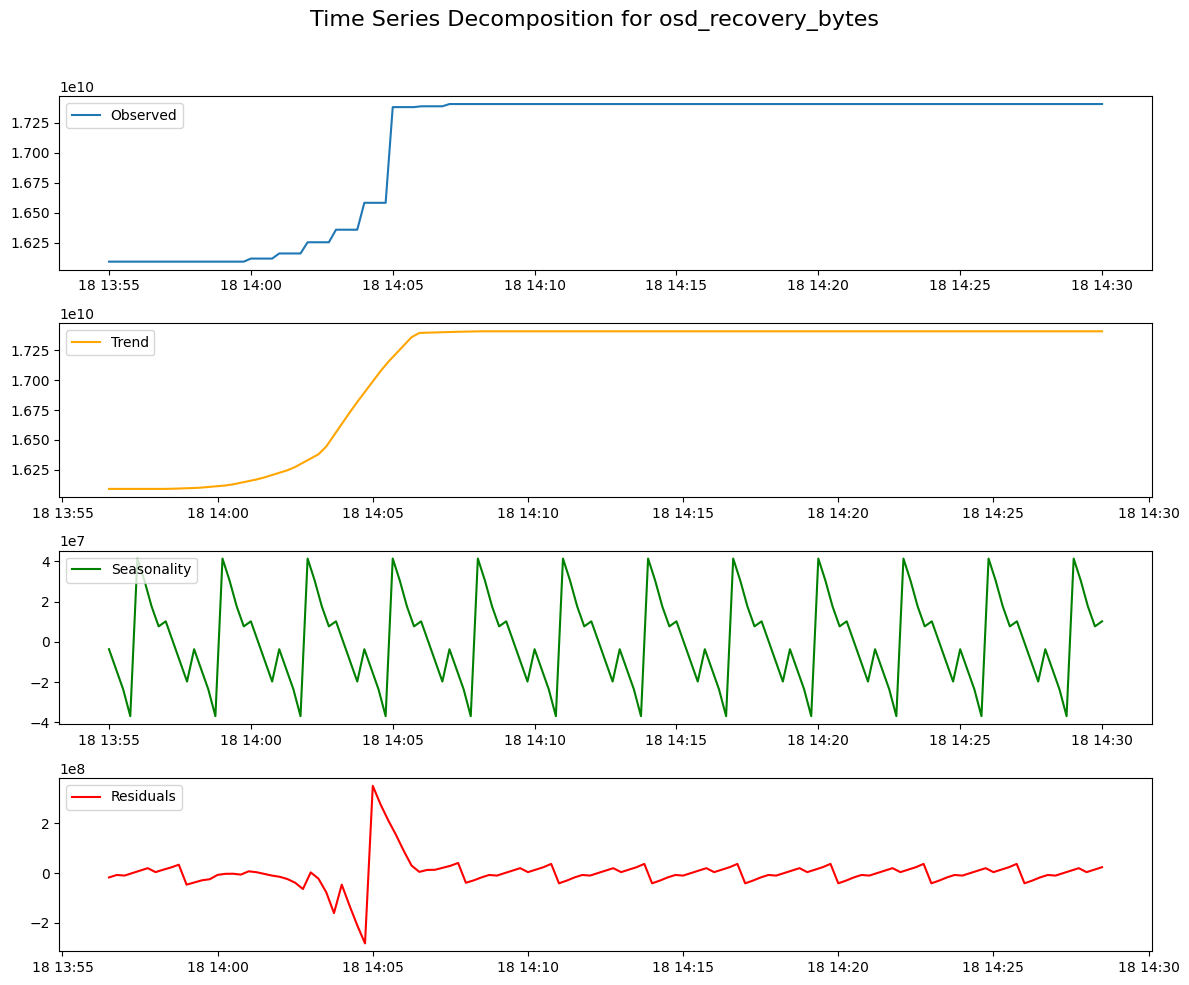

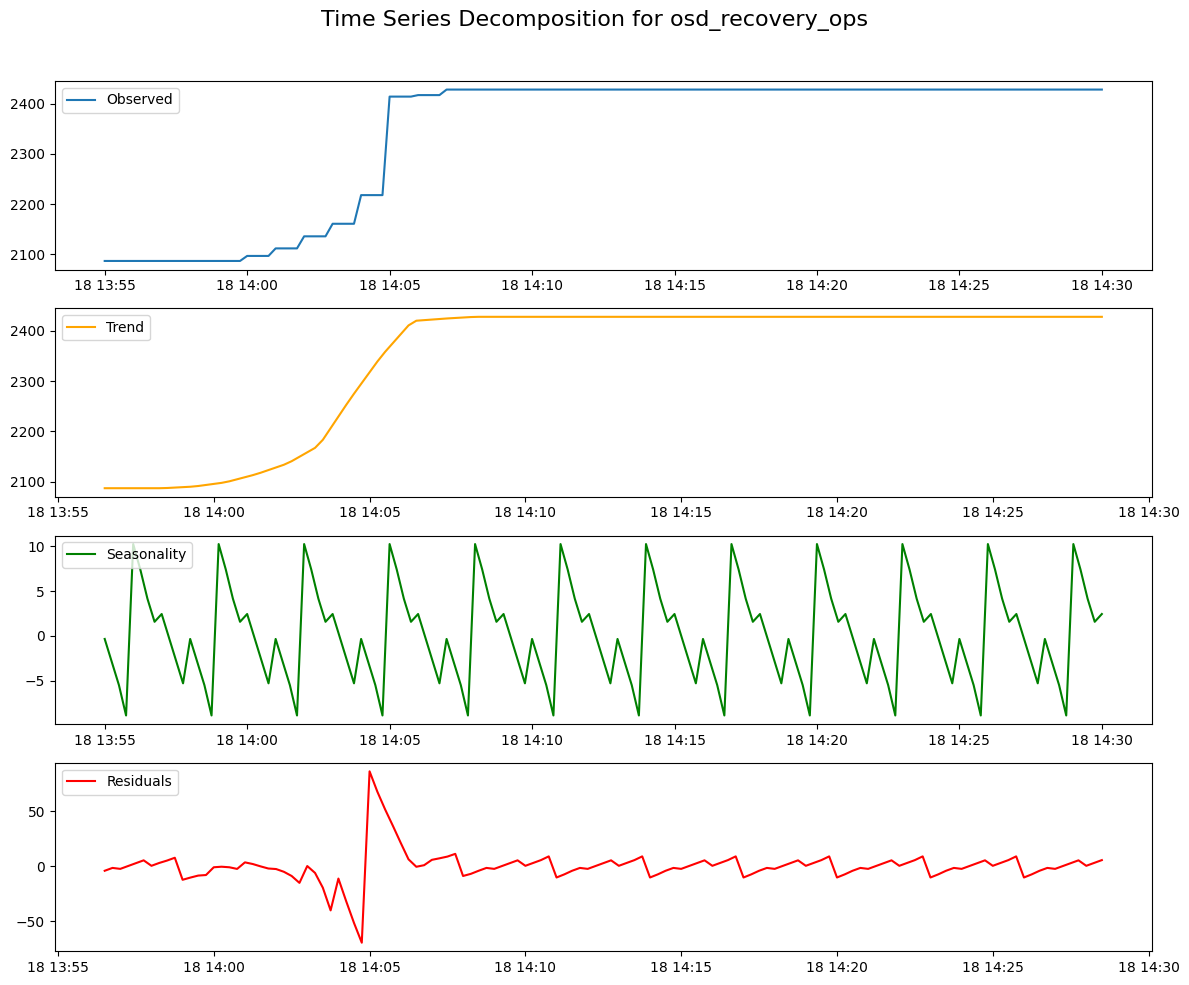

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Set timestamp as index
df_ts = df_final.set_index('timestamp')

# Resample to regular 5-second intervals to ensure clean time series
df_ts = df_ts.resample('5S').mean()

# Metrics to analyze
metrics_to_decompose = ['num_objects_degraded', 'osd_recovery_bytes', 'osd_recovery_ops']

for metric in metrics_to_decompose:
    if metric not in df_ts.columns:
        print(f"⚠️ Metric '{metric}' not found in data. Skipping.")
        continue

    series = df_ts[metric].dropna()

    if len(series) < 24:
        print(f"⚠️ Not enough data points to decompose '{metric}'. Need at least 24.")
        continue

    # Decompose with a 1-minute period (12 points at 5s intervals)
    decomposition = seasonal_decompose(series, model='additive', period=12)

    # Plot results
    plt.figure(figsize=(12, 10))
    plt.suptitle(f"Time Series Decomposition for {metric}", fontsize=16)

    plt.subplot(411)
    plt.plot(decomposition.observed, label='Observed')
    plt.legend(loc='upper left')

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend', color='orange')
    plt.legend(loc='upper left')

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonality', color='green')
    plt.legend(loc='upper left')

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals', color='red')
    plt.legend(loc='upper left')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


## Conclusion

### num_objects_degraded

**Observed**

*  The actual data values over time.

*  We see a sudden rise, a plateau, and then a gradual drop to zero, followed by a stable flat line.

**Trend**

* Captures the overall direction of the data.

* The trend rises initially and then declines steadily, reaching zero and staying flat.

* Interpretation: There was a temporary spike in degraded objects that later recovered or resolved.

**Seasonality**

* Repeating pattern every cycle (in this case, about every minute).

* Shows a clear repeating waveform, indicating some cyclical process happening regularly even when the main metric value is low.

* Interpretation: There's a systematic fluctuation possibly due to background checks or periodic events.

**Residual**
* What’s left after removing trend and seasonality — the noise or irregularities.

* High residuals at the beginning suggest unexpected variation during the initial spike.

* Residuals stabilize over time, indicating less unexpected behavior once the metric drops.

**Simple Summary:**
The number of degraded objects increased suddenly, stayed high for a short while, and then steadily dropped to zero. Despite this, there was a consistent underlying cyclical pattern in the data, and the unexpected behavior (residuals) was mostly present during the high-activity phase.

### osd_recovery_bytes

**Observed**

* The actual recorded values of osd_recovery_bytes over time.
* We observe a steady increase followed by a sudden and significant jump, after which the values plateau at a high level and remain flat.

**Trend**

* Represents the overall long-term movement in the data.
* The trend mirrors the observed plot — it increases gradually, then shows a sharp rise and stays flat at the elevated level.
* **Interpretation**: There's a major shift in the recovery activity, suggesting the system began handling a large data recovery workload that remained constant.

**Seasonality**

* Captures repeating short-term cycles in the data.
* Displays a regular and sharp cyclical pattern, with frequent ups and downs throughout the entire timeframe.
* **Interpretation**: Recovery operations exhibit periodic fluctuations, possibly due to scheduled background tasks, I/O patterns, or operational batch processes.

**Residual**

* The noise or randomness left after removing trend and seasonality from the observed data.
* A noticeable spike in residuals is seen at the time of the trend's sharp rise, followed by a general stabilization.
* **Interpretation**: There's a burst of irregular behavior during the transition into high recovery activity, but afterward, the system stabilizes with minimal unexpected variation.

**Simple Summary:**

The _osd_recovery_bytes_ metric shows a transition into a heavy and consistent data recovery phase, marked by a sharp jump and sustained high values. While the core trend stabilizes at a high level, regular cyclical activity continues to be present, suggesting predictable operational rhythms. Initial irregularities suggest some sudden system behavior before settling into a stable recovery state.

### osd_recovery_ops

**Observed**

* The actual values of osd_recovery_ops recorded over time.
* There is a gradual increase, followed by a sharp rise and then a stable plateau at a high level.

**Trend**

* Captures the underlying direction or pattern in the data over time.
* The trend follows a steady upward curve and then levels off at the elevated value.
* **Interpretation**: A sustained increase in recovery operations occurred, likely reflecting a new or escalated recovery workload.

**Seasonality**

* Represents repetitive, periodic fluctuations in the data.
* Exhibits a consistent and regular pattern, with sharp up-and-down movements throughout the timeline.
* **Interpretation**: There are underlying cyclic behaviors in recovery operations, possibly from regular background processes or system polling.

**Residual**

* Reflects irregularities not explained by trend or seasonality — essentially noise.
* There's a spike in residuals around the time the sharp increase occurs, then it settles into a more stable pattern.
* **Interpretation**: Anomalous activity was present during the sharp transition phase but diminished as the system reached steady state.

**Simple Summary:**

The _osd_recovery_ops_ metric shows a clear jump into a higher and stable operational state, likely driven by new recovery activity. Regular cyclical patterns indicate recurring system behavior, and unexpected variations were primarily limited to the moment of transition before the system stabilized.

# Step 11 : Normalized Time Series Plot for the selected metrics

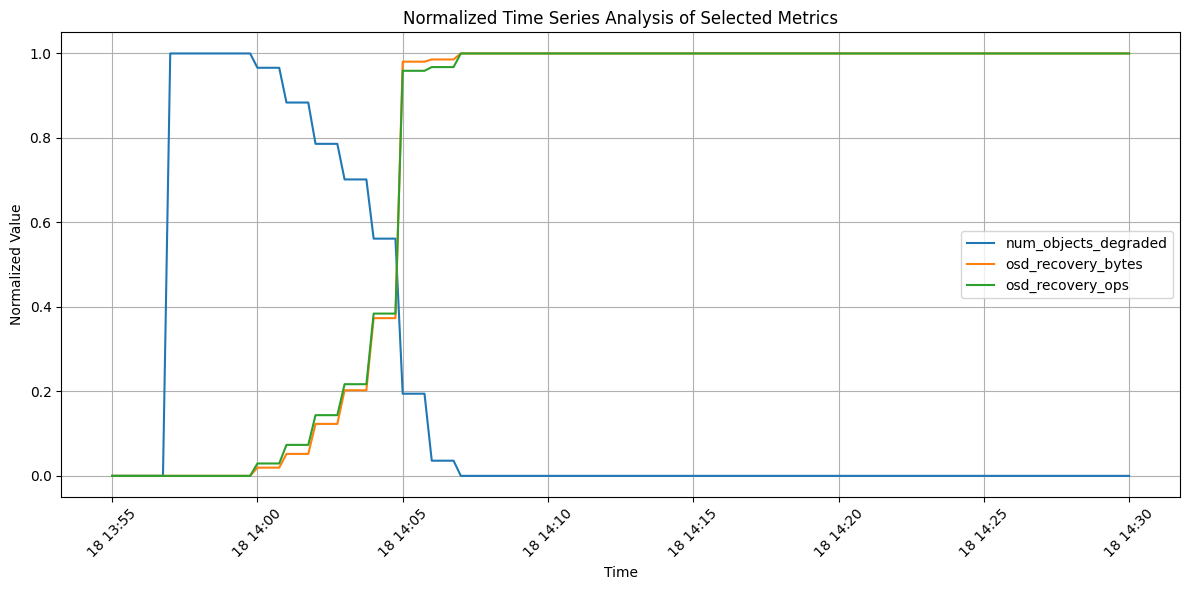

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Select and scale the metrics
scaler = MinMaxScaler()
scaled_metrics = scaler.fit_transform(df_final[available_metrics])
scaled_df = pd.DataFrame(scaled_metrics, columns=available_metrics)
scaled_df['timestamp'] = df_final['timestamp']

# Plot
plt.figure(figsize=(12, 6))
for metric in available_metrics:
    plt.plot(scaled_df['timestamp'], scaled_df[metric], label=metric)

plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.title("Normalized Time Series Analysis of Selected Metrics")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Step 12 : Time Series Prediction of num_objects_degraded, osd_recovery_bytes, osd_recovery_ops using Linear Regression Model

Mean Squared Error: 3.976592574402716e+16


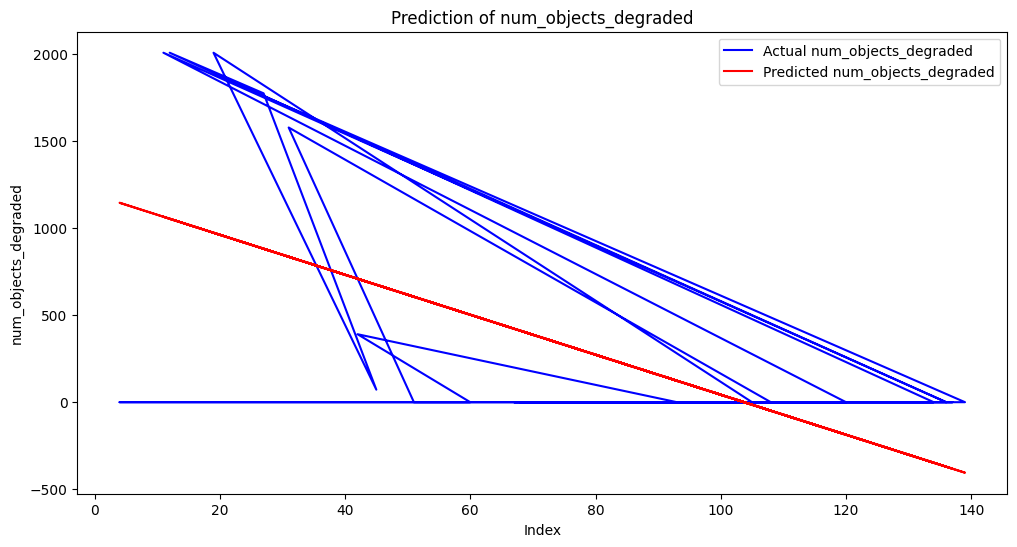

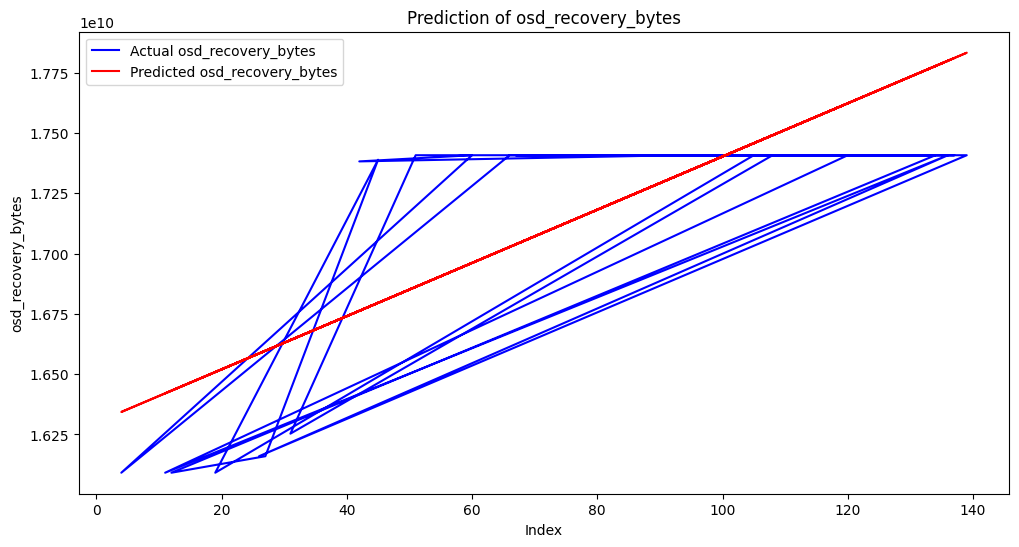

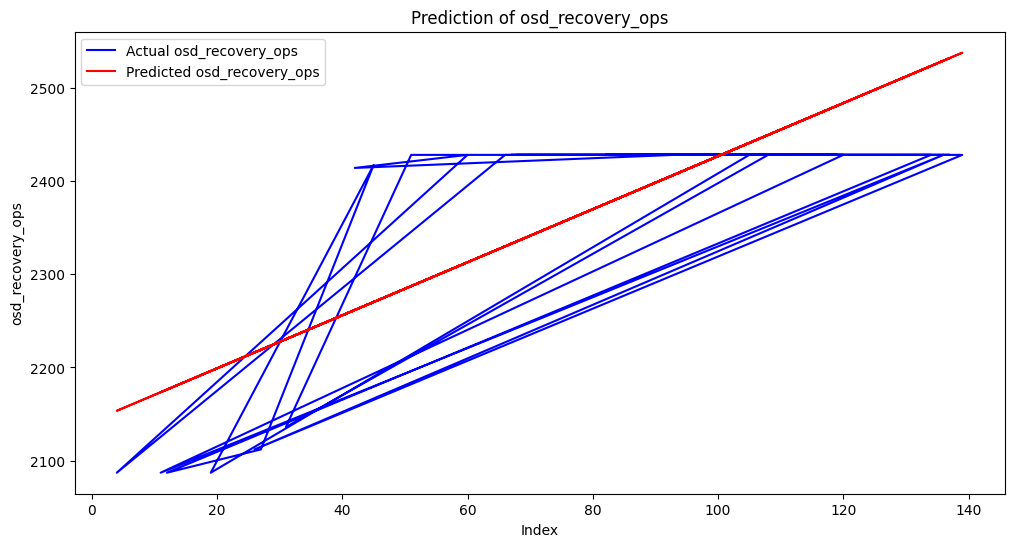

Predicted values for time 2023-04-01 10:00:00:
num_objects_degraded: -1.2852307211277522e+18
osd_recovery_bytes: 1.235758865661132e+24
osd_recovery_ops: 3.187820975704405e+17


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime

# Assuming you've uploaded the JSON files and parsed them into 'df'

# Step 1: Convert 'timestamp' to a numerical feature (seconds since the start)
df_final['timestamp'] = pd.to_datetime(df_final['timestamp'])
df_final['time_seconds'] = (df_final['timestamp'] - df_final['timestamp'].min()).dt.total_seconds()

# Step 2: Prepare features and target variables
# We'll predict the following metrics: num_objects_degraded, osd_recovery_bytes, osd_recovery_ops
features = ['time_seconds']
target_columns = ['num_objects_degraded', 'osd_recovery_bytes', 'osd_recovery_ops']

# Create the target and features datasets
X = df_final[features]
y = df_final[target_columns]

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train a regression model (Linear Regression in this case)
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 6: Evaluate the model (mean squared error)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Step 7: Visualize the predictions vs. actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test['num_objects_degraded'], label='Actual num_objects_degraded', color='blue')
plt.plot(y_test.index, y_pred[:, 0], label='Predicted num_objects_degraded', color='red')
plt.title('Prediction of num_objects_degraded')
plt.xlabel('Index')
plt.ylabel('num_objects_degraded')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test['osd_recovery_bytes'], label='Actual osd_recovery_bytes', color='blue')
plt.plot(y_test.index, y_pred[:, 1], label='Predicted osd_recovery_bytes', color='red')
plt.title('Prediction of osd_recovery_bytes')
plt.xlabel('Index')
plt.ylabel('osd_recovery_bytes')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test['osd_recovery_ops'], label='Actual osd_recovery_ops', color='blue')
plt.plot(y_test.index, y_pred[:, 2], label='Predicted osd_recovery_ops', color='red')
plt.title('Prediction of osd_recovery_ops')
plt.xlabel('Index')
plt.ylabel('osd_recovery_ops')
plt.legend()
plt.show()

# Step 8: Make predictions for a specific time input
# Input a specific time in the same format as the original timestamp
input_time_str = '2023-04-01 10:00:00'  # Example timestamp (change as needed)
input_time = datetime.strptime(input_time_str, '%Y-%m-%d %H:%M:%S')

# Convert the input time to seconds since the start
input_time_seconds = (input_time - df_final['timestamp'].min()).total_seconds()

# Predict the values for this time
predicted_values = model.predict(np.array([[input_time_seconds]]))

# Output the predicted values
print(f"Predicted values for time {input_time_str}:")
print(f"num_objects_degraded: {predicted_values[0][0]}")
print(f"osd_recovery_bytes: {predicted_values[0][1]}")
print(f"osd_recovery_ops: {predicted_values[0][2]}")
